# This notebook guide provides simples and relatively exhaustives examples of the capabilites of MODPATH 7 with MODFLOW 6

In [1]:
import flopy as fp
from flopy.utils.gridintersect import GridIntersect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon
from shapely.strtree import STRtree    
import os

In [2]:
# function that return the node number from the layer,row and coloumn index
def ikj2nn(node):
    return node[0]*nrow*ncol + node[1]*ncol + node[2]

In [3]:
def get_heads(model_name,workspace,obj=False):
    """
    Function that returns the heads from the headfile
    model_name : str, the name of the current model
    workspace : str, the path to workspace (where output files are stored)
    obj : bool, if we want to retrieve the head object rather than the computed heads for the last stress period
    """
    headfile = '{}.hds'.format(model_name)
    fname = os.path.join(workspace,headfile)    
    hdobj = fp.utils.HeadFile(fname, precision='double') 
    head  = hdobj.get_data()
    
    if obj:
        return hdobj
    else:
        return head

In [4]:
mpexe = "../../../../exe/mp7.exe"
mfexe = "../../../../exe/mf6.exe"
m_name = "mp_sim"
ws = "workspace"

## MODFLOW MODEL

In [5]:
# dis
nlay = 3
nrow = 30
ncol = 30
Lx = 100
Ly = 100
delc = Ly/nrow
delr = Lx/ncol
botm = [5,4,0]
top = 10

# parameters

kh = np.array([1e-4,1e-5,1e-4])
kv = kh/3

# tdis
nper = 1
p_d = (1,1.,1.)

## BC
riv1_spd = [((0,ir,0),10) for ir in range(nrow)]
riv2_spd = [((0,ir,ncol-1),7) for ir in range(nrow)]

loc_w = (2,15,15)
wel_spd = [(loc_w,-0.0015)]

# packages
sim = fp.mf6.MFSimulation(sim_name=m_name, exe_name=mfexe,version='mf6', sim_ws=ws)
tdis = fp.mf6.modflow.mftdis.ModflowTdis(sim, pname='tdis',time_units='DAYS', nper=nper,perioddata=[p_d])
gwf = fp.mf6.ModflowGwf(sim, modelname=m_name,model_nam_file=m_name+".nam", save_flows=True)
ims = fp.mf6.modflow.mfims.ModflowIms(sim,complexity="SIMPLE")
dis = fp.mf6.ModflowGwfdis(gwf,pname='dis', nlay=nlay,nrow=nrow, ncol=ncol,length_units='METERS',
                           delr=delr, delc=delc,top=top,botm=botm)
ic = fp.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname='ic', strt=top)
npf = fp.mf6.modflow.mfgwfnpf.ModflowGwfnpf(gwf, pname='npf',icelltype=[1,0,0], k=kh,k33=kv)
rch = fp.mf6.ModflowGwfrcha(gwf,recharge=700/1000/365/86400,save_flows=True)
wel = fp.mf6.ModflowGwfwel(gwf,pname="puits",maxbound=1,stress_period_data=wel_spd,save_flows=True)
riv1 = fp.mf6.ModflowGwfchd(gwf,pname="riv1",filename="riv1.chd",maxbound=len(riv1_spd),stress_period_data=riv1_spd)
riv2 = fp.mf6.ModflowGwfchd(gwf,pname="riv2",filename="riv2.chd",maxbound=len(riv2_spd),stress_period_data=riv2_spd)

# Create the output control package
oc = fp.mf6.modflow.mfgwfoc.ModflowGwfoc(gwf, pname='oc',
                                            saverecord=[('HEAD', 'ALL'),('BUDGET', 'ALL')],
                                            head_filerecord='{}.hds'.format(m_name),
                                            budget_filerecord='{}.cbc'.format(m_name))

In [6]:
sim.write_simulation(silent=True)
sim.run_simulation(silent=True)

(True, [])

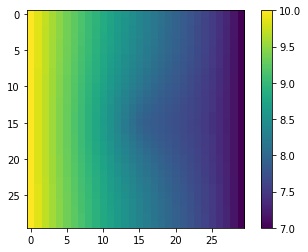

In [7]:
head = get_heads(m_name,ws)
plt.imshow(head[0])
plt.colorbar()

## MODPATH MODEL DATA

### First we need to define some things as zones and particle Groups

When creating particle groups we can define some parameters :
- **drape** : to decide what happen to a particle if it begins in a dry cell, 0 : remove, 1 : put in the uppermost active cell beneath the starting cell
- **localx/localy/localz** : to define the position inside the cell of the particles at the start of the simulation (0.5 means in the middle of the x,y or z axis, localz = 1 means the particle will be drop at the top of the cell)

With Modpath there's plenty different maners to instantiate particles. Some of them are presented just below :
   - 1 particle in each specified node (pg1)
   - multiples particles in a (or more) specific node (pg2)
   - Particles added by regions where the minimum layer, row and column as maximum must be provided

Broadly speaking, multiple particles can always be added in a cell and can be set anywhere in it with localx/localy/localz parameters. See doc for further explanations.

In [8]:
# MODPATH zones, this can be useful as a condition to stop the particles
zone_btm = np.ones((nrow, ncol))
zone_btm[loc_w[1:]] = 2
zones = [1, 1, zone_btm]

# Particles

# group 1, particles released at the left of the model in each layer
part_locs = []
part_ids = []
idx = 0
for ilay in range(nlay):
    for irow in range(nrow):
        idx += 1
        part_locs.append((ilay, irow, 1))
        part_ids.append(idx)
p_data1 = fp.modpath.ParticleData(part_locs, drape=0, structured=True, particleids=part_ids)
pg1 = fp.modpath.ParticleGroup(particlegroupname='PG1', particledata=p_data1,
                                  filename='ex01a.pg1.sloc')

# group 2, plenty of particles in the well :)
cd = fp.modpath.CellDataType(0,4,4,4)
Node_data = fp.modpath.NodeParticleData(cd,nodes = ikj2nn(loc_w))
pg2 = fp.modpath.ParticleGroupNodeTemplate(particlegroupname='PG2', particledata=Node_data,
                                  filename='ex01a.pg2.sloc')


# group 3, a particle in each cell of top layer ! be careful, it's a lot of particles and the simulation will take a certain amount of time
locsa = [[0, 0, 0, 0, nrow - 1, ncol - 1]]  # location for particles (minlay,minrow,mincol,maxlay,maxrow,maxcol)        
sd = fp.modpath.CellDataType(drape=0, columncelldivisions=1,
                                rowcelldivisions=1, layercelldivisions=1)
p = fp.modpath.LRCParticleData(subdivisiondata=sd,lrcregions=[locsa])
pg3 = fp.modpath.ParticleGroupLRCTemplate(particlegroupname='PG3',
                                                particledata=p,
                                                filename='ex01a.pg3.sloc')

# iface for MODFLOW 6
iface6 = {'RCH': 6, 'EVT': 6} 
# en gros pour dire la face de la cellule par laquelle le stress package doit agir (6 pour vers le haut)

## Modpath parameter simulation

Modpath needs 2 files to work properly : Basic and simulation files. First of all, a model must be instantiate with flopy with **Modpath7** method

Basic file contains infos about the porosity, cells that are constant, dry, etc. and also the default iface for stress package.

#### With flopy, Basic file is created using Modpath7Bas method


In [9]:
# create modpath files
exe_name = mpexe
mp = fp.modpath.Modpath7(modelname=m_name + '_mp', flowmodel=gwf,
                            exe_name=exe_name, model_ws=ws)
mpbas = fp.modpath.Modpath7Bas(mp, porosity=0.1,
                                  defaultiface=iface6)

### Simulation file

Is created with **Modpath7Sim** method and have MANYMANYMANY of parameters :
- **simulationtype** : Which type of simulation --> endpoint(only start and end data are recorded), pathline (every coordinates are recorded, timeseries (record only at time specified) and combined (all) 
- **trackingdirection** : forward or backward simulation
- **weaksinkoption & weaksourceoption** : to decide if a particle pass or not a certain weak source/sink (a cell assign as BC but let some flows pass through it (for example a cell where 1/2 of the flow goes into a well and the oterh 1/2 goes to another cell))
- **Budgetoutputoption** : How to print budget output results (I don't really know what this implies now)
- **budgetcellnumbers** : to specify cells for which detailed water budgets are computed
- **traceparticledata** : idk
- **referencetime** : start time for particles, can be set at a specific Stress period and time step (check documentation)
- **stoptimeoption** : how to stop particle tracking is stop : total --> stop at the end of the final time step, extend --> all particles tracked until they reach a termination location, specified --> tracked until particles reach a termination location OR reach the specified stop time 
- **stoptime** : only if stoptimeoption is specified, at which time stop particles
- **timepointdata** : only if sim is combined or time-series, list of 2 numbers : 1st is the number of interval and 2nd (float) is the interval between two time points (time will be stored each interval of this time)
- **zonedataoption** : (on or off) use zone to specify if you want that some particles stops when they reach a specific zone
- **stopzone** : goes with zonedataoption, zero based integer, -1 : no stop, 1,2 or greater to specify to stop in zone 1,2 or greater
- **zones** : array to indicate zones
- **retardationfactoroption** : to use the retardation factor or not
- **retardation** : array of domain size to determine the retardation factor in each cells
- **particlegroups** : particleGroup object (or list of them) with all the data for the particle tracking

In [10]:
mpsim = fp.modpath.Modpath7Sim(mp, simulationtype='combined',
                                  trackingdirection='forward',
                                  weaksinkoption='pass_through',
                                  weaksourceoption='pass_through',
                                  budgetoutputoption='summary',
                                  budgetcellnumbers=[1049, 1259],
                                  traceparticledata=[1, 1000],
                                  referencetime=[0, 0, 0.],
                                  stoptimeoption='extend',
                                  timepointdata=[500, 3600.],
                                  zonedataoption='on', zones=zones,
                                  particlegroups=[pg3])

In [11]:
# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

FloPy is using the following  executable to run the model: ../../../../exe/mp7.exe

MODPATH Version 7.2.001   
Program compiled Mar 21 2019 15:41:25 with IFORT compiler (ver. 19.0.0)         
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
       900 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

## Check results

First we need to have the cell numbers where the particles stop (well and rivers)

In [12]:
node_well = ikj2nn(loc_w)
node_riv1 = [ikj2nn(i) for i in riv1.stress_period_data.array[0].cellid]
node_riv2 = [ikj2nn(i) for i in riv2.stress_period_data.array[0].cellid]

### Retrieve Pathlines data

Pathlines are stored in the _mp.mppth file

In [13]:
fpth = os.path.join(ws, m_name + '_mp.mppth')
mp_file = fp.utils.PathlineFile(fpth)
pw = mp_file.get_destination_pathline_data(node_well)
pr = mp_file.get_destination_pathline_data(node_riv2)

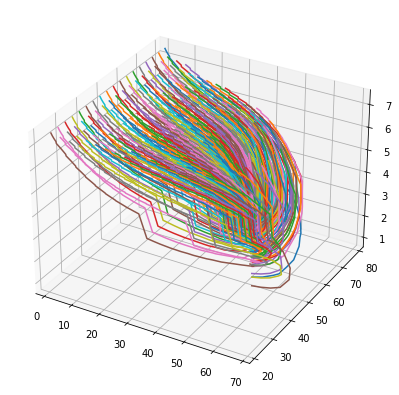

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,7))
ax = fig.gca(projection='3d')

p = pw

for i in range(len(p)):
    ax.plot(p[i].x,p[i].y,p[i].z)


### Endpoint data

In [15]:
fpth = os.path.join(ws, m_name + '_mp.mpend')
e = fp.utils.EndpointFile(fpth)

w_endp = e.get_destination_endpoint_data(dest_cells=node_well)
w_endp.time = w_endp.time / 86400
riv_endp = e.get_destination_endpoint_data(dest_cells=node_riv2)
epd_all = np.concatenate((w_endp,riv_endp))

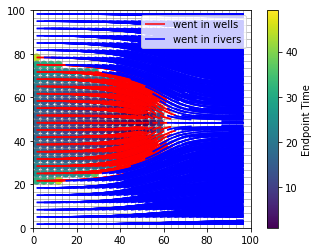

In [16]:
mm = fp.plot.PlotMapView(model=gwf,layer=0)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pw,color='red', label='went in wells')
mm.plot_pathline(pr,  color='blue', label='went in rivers')
mm.plot_endpoint(w_endp, direction='starting', colorbar=True)
mm.ax.legend();

#### plot contour lines for S zones protection

In [17]:
a = pd.DataFrame(w_endp)
a.reset_index(inplace=True)

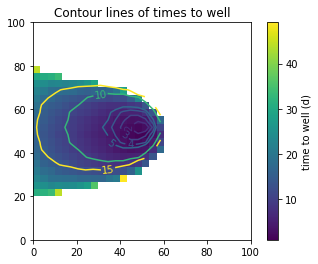

In [18]:
grid = gwf.modelgrid
time = np.ones([nrow,ncol])
time[time == 1] = None

for i in range(a.shape[0]):
    time[grid.intersect(a.loc[i,"x0"],a.loc[i,"y0"])] = a.loc[i,"time"]
    
cont = plt.contour(time,levels=[0,1,2,3,4,5,10,15],extent=[0, 100,0, 100])
plt.clabel(cont,fmt="%1i")
g = plt.imshow(time,extent=[0, 100,0, 100])
c = plt.colorbar(g)
plt.xlim(0,100)
plt.ylim(0,100)
plt.title("Contour lines of times to well")
c.set_label("time to well (d)")

### TimeSeries

In [19]:
fpth = os.path.join(ws, m_name + '_mp.timeseries')
ts = fp.utils.TimeseriesFile(fpth)

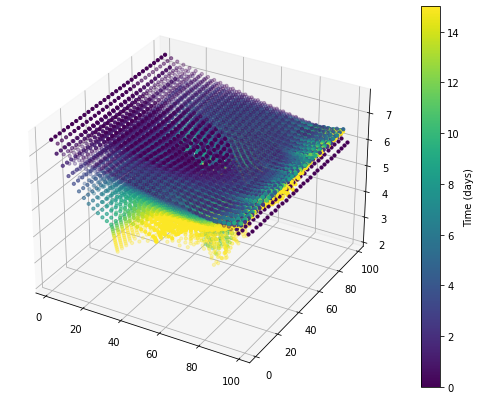

In [20]:
fig = plt.figure(figsize=(12,7))
ax = fig.gca(projection='3d')


for i in range(ts.get_maxid()):
    data = ts.get_data(i)
    data = data[::20]
    g = ax.scatter(data.x,data.y,data.z,c=data.time/86400,vmax=15,s=10)

cg = plt.colorbar(g)
cg.set_label("Time (days)")

## Backward tracking

In [21]:
mp = fp.modpath.Modpath7(modelname=m_name + '_mp', flowmodel=gwf,
                            exe_name=exe_name, model_ws=ws)
mpsim = fp.modpath.Modpath7Sim(mp, simulationtype='combined',
                                  trackingdirection='backward',
                                  weaksinkoption='pass_through',
                                  weaksourceoption='pass_through',
                                  referencetime=[0, 0, 0.],
                                  stoptimeoption='specified',
                                   stoptime=10*86400,
                                  timepointdata=[100, 86400.],
                                  zonedataoption='on', zones=zones,
                                  particlegroups=[pg2])

In [22]:
# write modpath datasets
mp.write_input()
# run modpath
mp.run_model()

FloPy is using the following  executable to run the model: ../../../../exe/mp7.exe

MODPATH Version 7.2.001   
Program compiled Mar 21 2019 15:41:25 with IFORT compiler (ver. 19.0.0)         
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
        64 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
         0 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

In [23]:
fpth = os.path.join(ws, m_name + '_mp.mppth')
mp_file = fp.utils.PathlineFile(fpth)
pwb = mp_file.get_destination_pathline_data(dest_cells=node_well)
prb = mp_file.get_destination_pathline_data(dest_cells=node_riv1)

Text(0.5, 0.92, 'zone of 10 days to well')

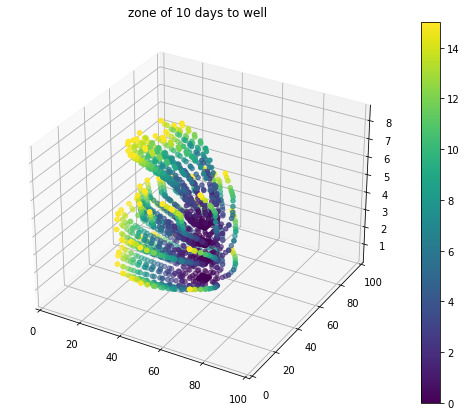

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig = plt.figure(figsize=(12,7))
ax = fig.gca(projection='3d')

df = pd.DataFrame()
for particle_tracing in pwb:
    a = pd.DataFrame(particle_tracing)
    
    df = df.append(a)

ax.scatter(df.x,df.y,df.z,c=df.time)
plt.colorbar(g)
plt.xlim(0,100)
plt.ylim(0,100)
plt.title("zone of 10 days to well")